In [1]:
# Cell 1: Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121, MobileNetV2
import cv2
import gc  # Garbage collector for memory management
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Force GPU usage and memory growth to avoid OOM errors
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s), memory growth enabled")
        
        # Enable mixed precision for faster training on compatible GPUs
        mixed_precision.set_global_policy('mixed_float16')
        print("Mixed precision enabled")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

# Optimize TensorFlow performance
tf.config.threading.set_inter_op_parallelism_threads(8)
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.data.experimental.AUTOTUNE

2025-05-20 17:18:13.005050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747761493.210085      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747761493.264860      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1 GPU(s), memory growth enabled
Mixed precision enabled
TensorFlow version: 2.18.0
GPU Available: True


-1

Using full dataset with subdirectories
Found 12 image directories
Loaded data entry file with 112120 records

First few rows of the metadata:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F           

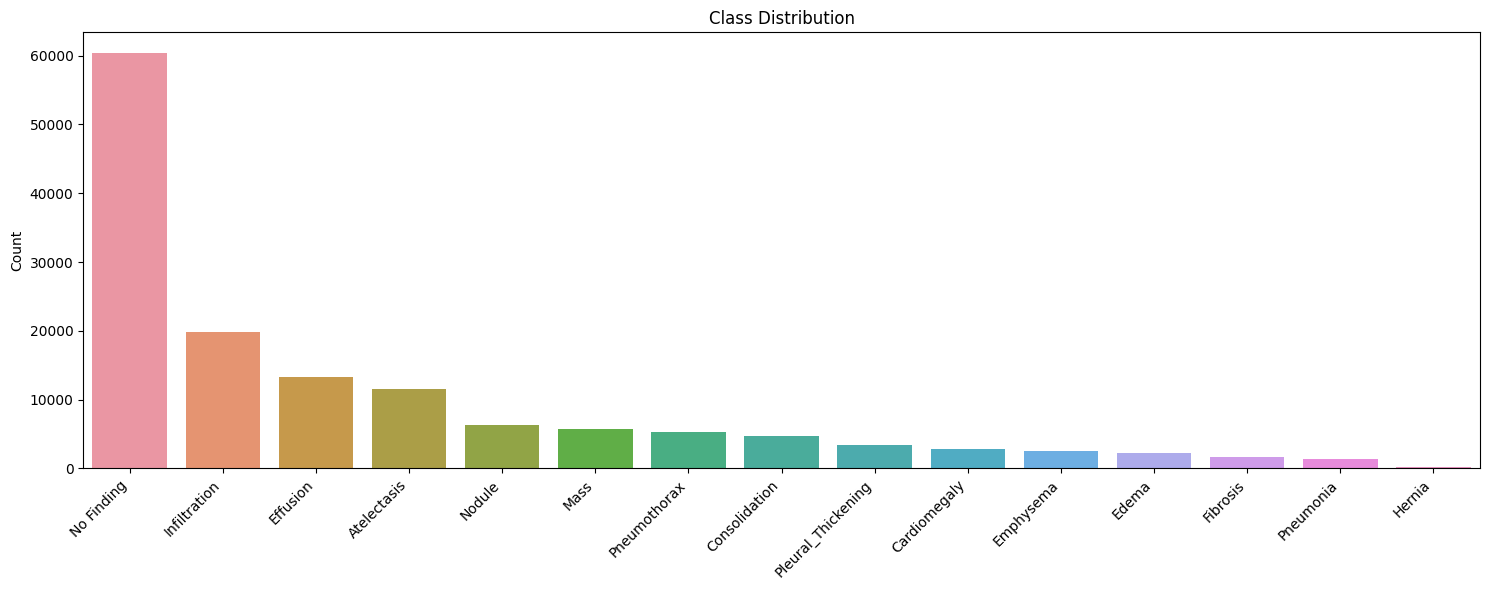

In [2]:
# Cell 2: Load and explore the dataset
# Set the base path to the dataset
base_path = '/kaggle/input/data'
images_path = os.path.join(base_path, 'images')

# Check if we're using the full dataset with subdirectories or a single directory
if os.path.exists(os.path.join(base_path, 'images_001')):
    print("Using full dataset with subdirectories")
    # Handle subdirectories
    image_dirs = [d for d in os.listdir(base_path) if d.startswith('images_')]
    image_dirs.sort()
    print(f"Found {len(image_dirs)} image directories")
else:
    print("Using dataset with single images directory")
    image_dirs = []

# Load the metadata file
data_entry_path = os.path.join(base_path, 'Data_Entry_2017.csv')
data_df = pd.read_csv(data_entry_path)
print(f"Loaded data entry file with {len(data_df)} records")

# Display the first few rows of the metadata
print("\nFirst few rows of the metadata:")
print(data_df.head())

# Check for class imbalance
print("\nClass distribution:")
findings = data_df['Finding Labels'].str.split('|', expand=True).stack()
findings = pd.DataFrame(findings.value_counts())
findings.columns = ['Count']
findings['Percentage'] = findings['Count'] / len(data_df) * 100
print(findings)

# Plot class distribution
plt.figure(figsize=(15, 6))
sns.barplot(x=findings.index, y='Count', data=findings)
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [3]:
# Cell 3: Define constants and prepare the data

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# === Constants ===
IMG_SIZE = 224  # Standard input size for many CNNs
BATCH_SIZE = 132


# === Get class names from dataset ===
class_names = findings.index.tolist()
print(f"📂 Classes: {class_names}")
num_classes = len(class_names)

# === Create class-to-index mapping ===
class_to_index = {class_name: i for i, class_name in enumerate(class_names)}

# === Create binary matrix for multilabel classification with progress bar ===
print("🧠 Encoding labels...")
def create_labels(row):
    labels = np.zeros(num_classes)
    if pd.notna(row['Finding Labels']):
        for finding in row['Finding Labels'].split('|'):
            if finding in class_to_index:
                labels[class_to_index[finding]] = 1
    return labels

# Apply with progress bar
tqdm.pandas(desc="Encoding labels")
data_df['Labels'] = data_df.progress_apply(create_labels, axis=1)

# === Fast image path mapping with progress bar ===
print("🔍 Scanning all image files...")

# 1. Preload all image paths from all subdirectories
all_image_paths = {}
for dir_name in tqdm(image_dirs, desc="Scanning subdirectories"):
    img_dir = os.path.join(base_path, dir_name, 'images')
    for root, _, files in os.walk(img_dir):
        for f in files:
            all_image_paths[f] = os.path.join(root, f)

print(f"✅ Found {len(all_image_paths):,} image files.")

# 2. Map each image index to its full path with progress bar
print("🔗 Mapping image indexes to paths...")
data_df['ImagePath'] = tqdm(data_df['Image Index'].map(all_image_paths), total=len(data_df), desc="Mapping paths")

# 3. Drop rows with missing image paths
initial_count = len(data_df)
data_df = data_df[data_df['ImagePath'].notna()]
print(f"✅ Valid images kept: {len(data_df):,} / {initial_count:,}")

# === Split into Train / Val / Test (stratified on first label) ===
print("✂️ Splitting data into train/val/test...")

def get_primary_label(label_string):
    return label_string.split('|')[0] if pd.notna(label_string) else 'NoLabel'

data_df['PrimaryLabel'] = data_df['Finding Labels'].apply(get_primary_label)

# First: Train/Test split
train_df, test_df = train_test_split(
    data_df,
    test_size=0.2,
    random_state=42,
    stratify=data_df['PrimaryLabel']
)

# Then: Train/Val split from train
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['PrimaryLabel']
)

print(f"📊 Training set:   {len(train_df):,} images")
print(f"📊 Validation set: {len(val_df):,} images")
print(f"📊 Test set:       {len(test_df):,} images")

# Free up memory
gc.collect()

📂 Classes: ['No Finding', 'Infiltration', 'Effusion', 'Atelectasis', 'Nodule', 'Mass', 'Pneumothorax', 'Consolidation', 'Pleural_Thickening', 'Cardiomegaly', 'Emphysema', 'Edema', 'Fibrosis', 'Pneumonia', 'Hernia']
🧠 Encoding labels...


Encoding labels: 100%|██████████| 112120/112120 [00:00<00:00, 115766.29it/s]


🔍 Scanning all image files...


Scanning subdirectories: 100%|██████████| 12/12 [02:25<00:00, 12.15s/it]


✅ Found 112,120 image files.
🔗 Mapping image indexes to paths...


Mapping paths: 100%|██████████| 112120/112120 [00:00<00:00, 3864326.63it/s]


✅ Valid images kept: 112,120 / 112,120
✂️ Splitting data into train/val/test...
📊 Training set:   71,756 images
📊 Validation set: 17,940 images
📊 Test set:       22,424 images


5238

In [4]:
# Cell 4: Create TF datasets
import tensorflow as tf
import gc

def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, label

def create_dataset(dataframe, batch_size, is_training=False):
    image_paths = dataframe['ImagePath'].values
    labels = np.stack(dataframe['Labels'].values)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda path, label: (preprocess_image(path), label),
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# ✅ Create datasets
train_dataset = create_dataset(train_df, BATCH_SIZE, is_training=True)
val_dataset = create_dataset(val_df, BATCH_SIZE)
test_dataset = create_dataset(test_df, BATCH_SIZE)

# 🧹 Clear up RAM
gc.collect()


I0000 00:00:1747761689.398304      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


0

In [5]:
# Custom F1 Score metric with adjustable threshold
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision(thresholds=self.threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=self.threshold)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        # Avoid division by zero
        return tf.cond(
            tf.less(p + r, 1e-7),
            lambda: tf.constant(0.0),
            lambda: 2 * ((p * r) / (p + r + 1e-7))
        )
    
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Calculate proper class weights based on actual class frequencies

In [6]:
def calculate_balanced_class_weights(df, class_names):
    """
    Calculate proper class weights based on inverse frequency with better normalization
    and a smoother distribution for highly imbalanced data
    """
    print("\n✅ Calculating balanced class weights...")
    # Count samples per class
    class_counts = {}
    class_weights = {}
    
    # Get counts for each class
    for i, class_name in enumerate(class_names):
        # Sum the binary labels for this class across all rows
        count = np.sum(np.stack(df['Labels'].values)[:, i])
        class_counts[class_name] = count
        
    # Calculate total samples and inverse frequency weights
    total_samples = sum(class_counts.values())
    
    # Use smoother weighting with sqrt to prevent extreme weights for rare classes
    max_count = max(class_counts.values())
    
    for class_name, count in class_counts.items():
        # Apply sqrt to smooth extreme weights while still helping rare classes
        # Add a small constant to avoid division by zero
        raw_weight = np.sqrt(max_count / (count + 1e-5))
        
        # Apply scaling to get reasonable weights
        class_weights[class_name] = min(max(raw_weight, 1.0), 5.0)  # Clip weights between 1.0 and 5.0
    
    # Print class counts and weights
    print("\n✅ Class counts and balanced weights:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {class_counts[class_name]} samples, weight = {class_weights[class_name]:.4f}")
    
    # Convert to the format needed by Keras (class index to weight)
    keras_class_weights = {i: class_weights[class_name] for i, class_name in enumerate(class_names)}
    return keras_class_weights

def create_balanced_dataset(df, class_names, max_samples_per_class=None):
    """
    Create a more balanced dataset by sampling from majority classes
    while keeping all samples from minority classes
    """
    print("\n🔄 Creating balanced dataset...")
    
    # Create empty dataframe for balanced data
    balanced_df = pd.DataFrame(columns=df.columns)
    
    # Count samples per class
    class_counts = {}
    for i, class_name in enumerate(class_names):
        # Get indices for rows where this class is present (label=1)
        class_indices = np.where(np.stack(df['Labels'].values)[:, i] == 1)[0]
        class_counts[class_name] = len(class_indices)
    
    # If no max samples specified, use 2x the median count as target
    if max_samples_per_class is None:
        median_count = np.median(list(class_counts.values()))
        # Use 2x median as max for majority classes, ensures we keep enough data
        max_samples_per_class = int(median_count * 2)
    
    print(f"✅ Target maximum samples per class: {max_samples_per_class}")
    
    # Process each class
    for i, class_name in enumerate(class_names):
        # Get indices for rows where this class is present (label=1)
        class_indices = np.where(np.stack(df['Labels'].values)[:, i] == 1)[0]
        class_size = len(class_indices)
        
        # For classes with more samples than our target, randomly sample
        if class_size > max_samples_per_class:
            # Random subsample
            selected_indices = np.random.choice(
                class_indices, size=max_samples_per_class, replace=False
            )
            print(f"⬇️ {class_name}: {class_size} → {len(selected_indices)} samples")
        else:
            # Keep all samples for minority classes
            selected_indices = class_indices
            print(f"✅ {class_name}: kept all {class_size} samples")
        
        # Add selected samples to our balanced dataframe
        balanced_df = pd.concat([balanced_df, df.iloc[selected_indices]], ignore_index=True)
    
    # Remove duplicates (due to multi-label nature, same image can be in multiple classes)
    initial_size = len(balanced_df)
    balanced_df = balanced_df.drop_duplicates(subset=['Image Index'])
    final_size = len(balanced_df)
    
    print(f"\n✅ Final balanced dataset: {final_size} samples")
    print(f"   (Removed {initial_size - final_size} duplicates)")
    
    return balanced_df

# Function to get more aggressive augmentation model (directly from paste.txt)
def get_augmentation_model():
    """
    Create a more aggressive data augmentation pipeline to help with class imbalance
    """
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),  # More aggressive flipping
        layers.RandomRotation(0.2),                   # More rotation
        layers.RandomZoom(0.2),                       # More zoom
        layers.RandomContrast(0.3),                   # More contrast variation
        layers.RandomTranslation(0.15, 0.15),         # More translation
        layers.RandomBrightness(0.2),                 # Add brightness variation
    ])
    return data_augmentation

# Improve dataset creation with balanced augmentation 
def create_balanced_tf_dataset(dataframe, batch_size, is_training=False, 
                             augmentation_factor=2):
    """
    Create TF dataset with better augmentation for minority classes
    """
    image_paths = dataframe['ImagePath'].values
    labels = np.stack(dataframe['Labels'].values)
    
    # Basic dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Apply preprocessing
    dataset = dataset.map(
        lambda path, label: (preprocess_image(path), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    if is_training:
        # Get our augmentation model
        data_augmentation = get_augmentation_model()
        
        # Map function to apply augmentation
        def apply_augmentation(image, label):
            image = data_augmentation(image, training=True)
            image = tf.cast(image, tf.float32)  # ✅ Explicitly cast back to float32
            return image, label

        
        # Augment the dataset
        augmented_dataset = dataset.map(
            apply_augmentation,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        # Combine original and augmented datasets
        dataset = dataset.concatenate(augmented_dataset)
        
        # Add more augmentation for minority classes
        minority_classes = ['Hernia', 'Pneumonia', 'Fibrosis', 'Edema']
        
        # Extract indices for minority classes
        minority_indices = []
        for class_name in minority_classes:
            if class_name in class_names:
                idx = class_names.index(class_name)
                # Find samples with this label=1
                class_mask = labels[:, idx] == 1
                minority_indices.extend(np.where(class_mask)[0])
        
        # Create dataset just for minority classes
        if minority_indices:
            minority_paths = image_paths[minority_indices]
            minority_labels = labels[minority_indices]
            
            minority_dataset = tf.data.Dataset.from_tensor_slices(
                (minority_paths, minority_labels)
            )
            
            # Apply preprocessing and heavy augmentation
            minority_dataset = minority_dataset.map(
                lambda path, label: (preprocess_image(path), label),
                num_parallel_calls=tf.data.AUTOTUNE
            )
            
            # Apply multiple augmentations to minority samples
            augmented_minority = minority_dataset
            for _ in range(augmentation_factor):
                augmented_batch = minority_dataset.map(
                    apply_augmentation,
                    num_parallel_calls=tf.data.AUTOTUNE
                )
                augmented_minority = augmented_minority.concatenate(augmented_batch)
            
            # Add augmented minority samples to main dataset
            dataset = dataset.concatenate(augmented_minority)
        
        # Shuffle after augmentation to mix everything properly
        dataset = dataset.shuffle(buffer_size=10000)
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def balance_train_dataset():
    """Main function to create a balanced dataset for training"""
    global train_df, val_df, test_df, train_dataset, val_dataset, test_dataset, class_names
    
    # 1. Balance the training data
    balanced_train_df = create_balanced_dataset(train_df, class_names)
    
    # 2. Recalculate class weights based on new distribution
    balanced_class_weights = calculate_balanced_class_weights(balanced_train_df, class_names)
    
    # 3. Create new TF datasets with better augmentation
    new_train_dataset = create_balanced_tf_dataset(
        balanced_train_df, BATCH_SIZE, is_training=True, augmentation_factor=3)
    
    # Keep validation and test datasets as is to reflect real-world distribution
    new_val_dataset = create_dataset(val_df, BATCH_SIZE)
    new_test_dataset = create_dataset(test_df, BATCH_SIZE)
    
    # Return everything needed
    return (balanced_train_df, balanced_class_weights, 
            new_train_dataset, new_val_dataset, new_test_dataset)



# Better focal loss implementation with class weighting
def balanced_focal_loss(class_weights=None, gamma=2.0, alpha=0.25):
    """
    Better focal loss implementation with proper class weighting
    and alpha parameter for positive/negative balance
    """
    def loss_function(y_true, y_pred):
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Cross entropy base
        ce_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        
        # Apply focal weighting
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = tf.pow(1.0 - p_t, gamma)
        
        # Apply class weights if provided
        if class_weights is not None:
            # Convert dict to tensor with shape [1, num_classes]
            weight_values = tf.constant([class_weights[i] for i in range(len(class_weights))], 
                                       dtype=tf.float32)
            class_weight_tensor = tf.reshape(weight_values, [1, -1])
            
            # Higher weights for positive examples of rare classes
            # Base alpha for balancing pos/neg examples + class-specific weights
            alpha_t = y_true * (alpha * class_weight_tensor) + (1 - y_true) * (1 - alpha)
            focal_weighted_ce = alpha_t * focal_weight * ce_loss
        else:
            # Default alpha-balanced focal loss
            alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
            focal_weighted_ce = alpha_t * focal_weight * ce_loss
        
        return tf.reduce_mean(focal_weighted_ce)
    
    return loss_function


# Build improved model with DenseNet121 and better architecture
def build_improved_model(input_shape, num_classes, class_weights=None):
    """
    Build an improved model with DenseNet121 backbone and more effective 
    architecture for medical imaging
    """
    # Create augmentation layers
    data_augmentation = get_augmentation_model()
    
    # Create input layer
    inputs = layers.Input(shape=input_shape)
    
    # Apply augmentation during training only
    x = data_augmentation(inputs)
    
    # DenseNet121 pre-trained model (better than MobileNetV2 for medical imaging)
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Fine-tune more layers - train almost the entire network
    fine_tune_at = 100  # Only freeze first 100 layers (instead of all but 40)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Connect base model
    x = base_model(x, training=False)
    
    # Better feature extraction with global pooling variants
    gap = layers.GlobalAveragePooling2D()(x)
    gmp = layers.GlobalMaxPooling2D()(x)
    
    # Combine pooling strategies for more robust features
    x = layers.Concatenate()([gap, gmp])
    
    # Batch normalization for more stable training
    x = layers.BatchNormalization()(x)
    
    # First dense block with more units
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)  # High dropout for better regularization
    
    # Second dense block with reasonable size
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    
    # Lower threshold for output layer to increase recall
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Optimizer with weight decay and learning rate warmup
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-4,  # Start with slightly higher learning rate
        weight_decay=1e-5    # Add weight decay for regularization
    )
    
    # Better threshold for improved recall on rare classes
    threshold = 0.3  # Lower threshold improves recall on imbalanced data
    
    # Add all relevant metrics
    f1_score = F1Score(name='f1_score', threshold=threshold)
    precision = tf.keras.metrics.Precision(thresholds=threshold, name='precision')
    recall = tf.keras.metrics.Recall(thresholds=threshold, name='recall')
    
    # Use the enhanced focal loss with class weights
    loss_fn = balanced_focal_loss(class_weights, gamma=2.0, alpha=0.25)
    
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=threshold),
            tf.keras.metrics.AUC(name='auc', curve='PR'),  # PR curve for imbalanced data
            tf.keras.metrics.AUC(name='roc_auc', curve='ROC'),  # Also track ROC AUC
            precision,
            recall,
            f1_score
        ]
    )
    
    return model

# One unified set of callbacks for better monitoring
def get_optimized_callbacks(monitor_metric='val_f1_score'):
    """
    Create a single optimized set of callbacks with better parameters
    """
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor=monitor_metric,
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    # More patience to allow learning on difficult classes
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor=monitor_metric,
        patience=15,  
        verbose=1,
        mode='max',
        restore_best_weights=True
    )

    # More gradual LR reduction
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=4,
        verbose=1,
        min_lr=1e-7
    )

    # Better TensorBoard monitoring
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1,
        update_freq='epoch',
        profile_batch=0  # Disable profiling to avoid slowdowns
    )

    return [model_checkpoint, early_stopping, reduce_lr, tensorboard]


🔄 Creating balanced dataset...
✅ Target maximum samples per class: 5954
⬇️ No Finding: 38631 → 5954 samples
⬇️ Infiltration: 12709 → 5954 samples
⬇️ Effusion: 8556 → 5954 samples
⬇️ Atelectasis: 7401 → 5954 samples
✅ Nodule: kept all 4099 samples
✅ Mass: kept all 3706 samples
✅ Pneumothorax: kept all 3445 samples
✅ Consolidation: kept all 2977 samples
✅ Pleural_Thickening: kept all 2193 samples
✅ Cardiomegaly: kept all 1768 samples
✅ Emphysema: kept all 1620 samples
✅ Edema: kept all 1489 samples
✅ Fibrosis: kept all 1080 samples
✅ Pneumonia: kept all 936 samples
✅ Hernia: kept all 143 samples

✅ Final balanced dataset: 34314 samples
   (Removed 12958 duplicates)

✅ Calculating balanced class weights...

✅ Class counts and balanced weights:
No Finding: 5954.0 samples, weight = 1.2476
Infiltration: 9268.0 samples, weight = 1.0000
Effusion: 7576.0 samples, weight = 1.1060
Atelectasis: 6726.0 samples, weight = 1.1739
Nodule: 4099.0 samples, weight = 1.5037
Mass: 3706.0 samples, weight = 

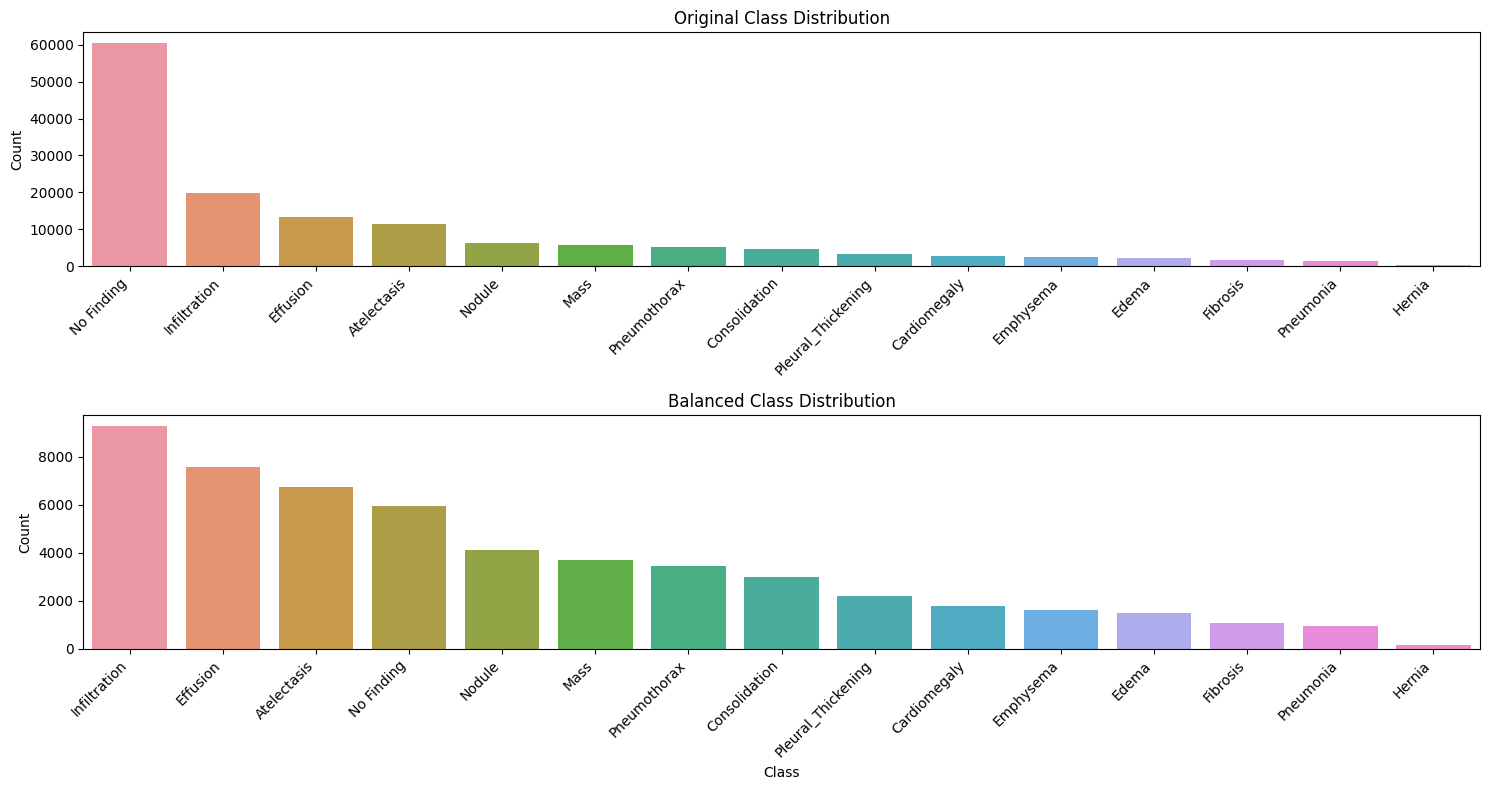

Training on 34314 images with batch size 132
Using DenseNet121 model with adaptive focal loss
Number of classes: 15
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


I0000 00:00:1747761894.322185      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5436 - auc: 0.1237 - f1_score: 0.2040 - loss: 0.1068 - precision: 0.1264 - recall: 0.5610 - roc_auc: 0.5681
Epoch 1: val_f1_score improved from -inf to 0.09584, saving model to best_model.keras
631/631 ━━━━━━━━━━━━━━━━━━━━ 1517s 2s/step - accuracy: 0.5438 - auc: 0.1237 - f1_score: 0.2041 - loss: 0.1068 - precision: 0.1264 - recall: 0.5609 - roc_auc: 0.5682 - val_accuracy: 0.1712 - val_auc: 0.0557 - val_f1_score: 0.0958 - val_loss: 0.0585 - val_precision: 0.0528 - val_recall: 0.5238 - val_roc_auc: 0.2952 - learning_rate: 1.0000e-04
Epoch 2/5
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7320 - auc: 0.1631 - f1_score: 0.2428 - loss: 0.0486 - precision: 0.1719 - recall: 0.4145 - roc_auc: 0.6321
Epoch 2: val_f1_score improved from 0.09584 to 0.12188, saving model to best_model.keras
631/631 ━━━━━━━━━━━━━━━━━━━━ 1353s 2s/step - accuracy: 0.7320 - auc: 0.1631 - f1_score: 0.2428 - loss: 0.0486 - precision: 0.1719 - recall: 0.4145 -

In [7]:
def train_and_evaluate_balanced_model(
    train_df, val_df, test_df,
    train_dataset, val_dataset, test_dataset,
    IMG_SIZE, BATCH_SIZE, num_classes, class_names,
    class_weights=None,
    epochs=5
):
    print(f"Training on {len(train_df)} images with batch size {BATCH_SIZE}")
    print("Using DenseNet121 model with adaptive focal loss")
    print(f"Number of classes: {num_classes}")
    # 1. Build model
    model = build_improved_model(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        num_classes=num_classes,
        class_weights=class_weights
    )
    # 2. Setup callbacks
    callbacks = get_optimized_callbacks(monitor_metric='val_f1_score')
    # 3. Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    # 4. Evaluate on test set
    print("\n🧪 Evaluating on test set:")
    test_metrics = model.evaluate(test_dataset)
    for name, value in zip(model.metrics_names, test_metrics):
        print(f"{name}: {value:.4f}")
    return model, history

# Execute the balanced training strategy
# 1. Create balanced dataset and class weights
balanced_train_df, balanced_class_weights, balanced_train_dataset, balanced_val_dataset, balanced_test_dataset = balance_train_dataset()
# Plot the class distribution of our balanced training set
def plot_balanced_distribution():
    balanced_findings = []
    for i, class_name in enumerate(class_names):
        # Count occurrences of this class in our balanced dataset
        count = np.sum(np.stack(balanced_train_df['Labels'].values)[:, i])
        balanced_findings.append({"Class": class_name, "Count": count})

    balanced_df = pd.DataFrame(balanced_findings)
    balanced_df = balanced_df.sort_values(by="Count", ascending=False)

    # Plot both original and balanced distributions
    plt.figure(figsize=(15, 8))

    # Original distribution (using findings from earlier)
    ax1 = plt.subplot(2, 1, 1)
    sns.barplot(x=findings.index, y='Count', data=findings, ax=ax1)
    plt.title('Original Class Distribution')
    plt.xticks(rotation=45, ha='right')

    # Balanced distribution
    ax2 = plt.subplot(2, 1, 2)
    sns.barplot(x="Class", y="Count", data=balanced_df, ax=ax2)
    plt.title('Balanced Class Distribution')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('class_distribution_comparison.png')
    plt.show()
# Plot the distribution comparison
plot_balanced_distribution()
# 2. Train the improved model with our balanced dataset
improved_model, history = train_and_evaluate_balanced_model(
    balanced_train_df, val_df, test_df,
    balanced_train_dataset, balanced_val_dataset, balanced_test_dataset,
    IMG_SIZE=IMG_SIZE, BATCH_SIZE=BATCH_SIZE, 
    num_classes=num_classes, class_names=class_names,
    class_weights=balanced_class_weights,
    epochs=5
)
# 3. Plot training metrics
def plot_training_metrics(history):
    """Plot all training metrics in a comprehensive dashboard"""
    plt.figure(figsize=(20, 15))

    metrics = [
        ('loss', 'Loss', 'lower'), 
        ('accuracy', 'Accuracy', 'higher'),
        ('auc', 'PR-AUC', 'higher'),
        ('roc_auc', 'ROC-AUC', 'higher'),
        ('precision', 'Precision', 'higher'),
        ('recall', 'Recall', 'higher'),
        ('f1_score', 'F1 Score', 'higher')
    ]

    for i, (metric_name, title, goal) in enumerate(metrics):
        plt.subplot(3, 3, i+1)

        if metric_name in history.history:
            plt.plot(history.history[metric_name], label=f'Training {title}')

        if f'val_{metricname}' in history.history:
            plt.plot(history.history[f'val{metric_name}'], label=f'Validation {title}')

        plt.title(f'{title} ({goal} is better)')
        plt.xlabel('Epoch')
        plt.ylabel(title)

In [20]:
# Cell 9: Visualize some predictions
def visualize_predictions(generator, model, num_images=5):
    """Visualize model predictions on a few images."""
    batch_x, batch_y = generator[0]
    preds = model.predict(batch_x)
    
    plt.figure(figsize=(20, 4 * num_images))
    for i in range(min(num_images, len(batch_x))):
        # Original image
        plt.subplot(num_images, 2, i*2+1)
        plt.imshow(batch_x[i])
        
        true_findings = [class_names[j] for j in range(num_classes) if batch_y[i][j] == 1]
        title = 'True: ' + ', '.join(true_findings)
        plt.title(title, fontsize=10)
        plt.axis('off')
        
        # Predictions
        plt.subplot(num_images, 2, i*2+2)
        
        # Plot as a bar chart
        y_pos = np.arange(num_classes)
        plt.barh(y_pos, preds[i])
        plt.yticks(y_pos, class_names)
        plt.xlabel('Probability')
        plt.title('Predictions', fontsize=10)
        plt.tight_layout()
        
        # Highlight predictions above threshold
        pred_findings = [class_names[j] for j in range(num_classes) if preds[i][j] > 0.5]
        pred_text = 'Predicted: ' + ', '.join(pred_findings)
        plt.figtext(0.5, 0.98-i*0.2, pred_text, ha='center', fontsize=12, 
                   bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize some test predictions
print("Sample predictions:")
visualize_predictions(balanced_test_dataset, improved_model)

Sample predictions:


TypeError: '_PrefetchDataset' object is not subscriptable

In [11]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Assuming balanced_focal_loss is defined in your code
def balanced_focal_loss(y_true, y_pred):
    # Your implementation of balanced_focal_loss goes here
    # Replace this with your actual function definition
    pass

# After training the model
improved_model, history = train_and_evaluate_balanced_model(
    balanced_train_df, val_df, test_df,
    balanced_train_dataset, balanced_val_dataset, balanced_test_dataset,
    IMG_SIZE=IMG_SIZE, BATCH_SIZE=BATCH_SIZE, 
    num_classes=num_classes, class_names=class_names,
    class_weights=balanced_class_weights,
    epochs=5
)

# Save the trained model
print("Saving the trained model to 'my_trained_model.keras'...")
improved_model.save('my_trained_model.keras')
print("Model saved successfully!")

Training on 34314 images with batch size 132
Using DenseNet121 model with adaptive focal loss
Number of classes: 15


TypeError: balanced_focal_loss() got an unexpected keyword argument 'gamma'

In [12]:
# Cell 11: Function for using a subset of data if needed
def create_data_subset(df, samples_per_class=500):
    """
    Create a balanced subset of the data with a specified number of samples per class.
    This is useful if you encounter memory issues with the full dataset.
    """
    subset_indices = []
    
    for i, class_name in enumerate(class_names):
        # Find indices where this class is present
        class_indices = df.index[df.apply(lambda row: row['Labels'][i] == 1, axis=1)].tolist()
        
        # If we have too few samples, use all of them
        if len(class_indices) <= samples_per_class:
            subset_indices.extend(class_indices)
        else:
            # Otherwise, sample the requested number
            subset_indices.extend(np.random.choice(class_indices, samples_per_class, replace=False))
    
    # Remove duplicates (some images belong to multiple classes)
    subset_indices = list(set(subset_indices))
    
    # Return the subset dataframe
    return df.loc[subset_indices].reset_index(drop=True)

# Example of how to use the subset function if needed
# Uncomment the following lines if you need to use a smaller dataset
"""
# Create balanced subsets
train_subset = create_data_subset(train_df, samples_per_class=300)
val_subset = create_data_subset(val_df, samples_per_class=100)
test_subset = create_data_subset(test_df, samples_per_class=100)

print(f"Training subset: {len(train_subset)} images")
print(f"Validation subset: {len(val_subset)} images")
print(f"Test subset: {len(test_subset)} images")

# Create generators with the subsets
train_generator_subset = XrayDataGenerator(train_subset, BATCH_SIZE, IMG_SIZE, augment=True)
val_generator_subset = XrayDataGenerator(val_subset, BATCH_SIZE, IMG_SIZE, augment=False)
test_generator_subset = XrayDataGenerator(test_subset, BATCH_SIZE, IMG_SIZE, augment=False, shuffle=False)

# Then use these generators instead of the full dataset generators
"""

'\n# Create balanced subsets\ntrain_subset = create_data_subset(train_df, samples_per_class=300)\nval_subset = create_data_subset(val_df, samples_per_class=100)\ntest_subset = create_data_subset(test_df, samples_per_class=100)\n\nprint(f"Training subset: {len(train_subset)} images")\nprint(f"Validation subset: {len(val_subset)} images")\nprint(f"Test subset: {len(test_subset)} images")\n\n# Create generators with the subsets\ntrain_generator_subset = XrayDataGenerator(train_subset, BATCH_SIZE, IMG_SIZE, augment=True)\nval_generator_subset = XrayDataGenerator(val_subset, BATCH_SIZE, IMG_SIZE, augment=False)\ntest_generator_subset = XrayDataGenerator(test_subset, BATCH_SIZE, IMG_SIZE, augment=False, shuffle=False)\n\n# Then use these generators instead of the full dataset generators\n'

In [21]:
import tensorflow as tf

class BalancedFocalLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights=None, gamma=2.0, alpha=0.25, name='balanced_focal_loss'):
        super().__init__(name=name)
        self.class_weights = class_weights  # List or dict of class weights
        self.gamma = gamma                 # Focal loss gamma parameter
        self.alpha = alpha                 # Focal loss alpha parameter

    def call(self, y_true, y_pred):
        # Small constant to prevent log(0)
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Compute cross-entropy loss
        ce_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

        # Compute focal weighting
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = tf.pow(1.0 - p_t, self.gamma)

        # Apply class weights and alpha
        if self.class_weights is not None:
            weight_values = tf.constant(
                [self.class_weights[i] for i in range(len(self.class_weights))], 
                dtype=tf.float32
            )
            class_weight_tensor = tf.reshape(weight_values, [1, -1])
            alpha_t = y_true * (self.alpha * class_weight_tensor) + (1 - y_true) * (1 - self.alpha)
            focal_weighted_ce = alpha_t * focal_weight * ce_loss
        else:
            alpha_t = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
            focal_weighted_ce = alpha_t * focal_weight * ce_loss

        # Return the mean loss
        return tf.reduce_mean(focal_weighted_ce)

    def get_config(self):
        # Serialize the class parameters
        config = super().get_config()
        config.update({
            'class_weights': self.class_weights,
            'gamma': self.gamma,
            'alpha': self.alpha
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Deserialize the class from the config
        return cls(**config)